# SC13 Team 8

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

# Practical Motivation

Kickstarter is a corporation that maintains a crowdfunding platform for creative projects. To date, over USD 6 Billion dollars have been pledged to kickstarter projects with over 200,000 successfully funded projects. However, over 300,000 projects are unsuccessful in funding.

How can kickstarter campaign starters reduce their chances of failing?

Problem definition: How do different variables affect the failure of kickstarter campaigns?

# Data Extraction

Since Kickstarter does not have a public api, we are not going to scrape off their website using available tools. Instead, we will use the 2018 dataset from Kaggle.

In [2]:
ksData = pd.read_csv('ks-projects-201801.csv')

In [3]:
ksData.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
ksData.shape

(378661, 15)

The 2018 dataset has a size of 378661 x 15.

# Data Cleaning and Preparation

First, let us explore the different variables we're working with to make sure only relevant data is kept.

In [5]:
for col in ksData.columns:
    print(col)

ID
name
category
main_category
currency
deadline
goal
launched
pledged
state
backers
country
usd pledged
usd_pledged_real
usd_goal_real


Since we are exploring how different variables affect the failure of kickstarter campaigns, we will first remove the variables that do not affect the failure at all.

These variables include:

ID - since ID is a unique tag given by Kickstarter, it does not have any meaning

currency - whether it is in USD or GBP, the value is equal when converted, it does not matter.

country- since Kickstarter is a global platform, although success rates may vary by country, changing the country to reduce the failure rates is not feasible.

In [6]:
ksData.drop(columns=['ID','currency','country'], inplace = True)

Next, we remove any variables that are tied to our response variable "state" since they do not give additional insight.

These variables include: pledged, backers, usd pledged and usd_pledged_real.

In [7]:
ksData.drop(columns=['pledged', 'backers', 'usd pledged', 'usd_pledged_real'], inplace = True)

Since we are already using main_category, we can exclude category as a variable. Same case for goal and usd_goal_real

In [8]:
ksData.drop(columns=['category', 'goal'], inplace = True)

In [9]:
for col in ksData.columns:
    print(col)

name
main_category
deadline
launched
state
usd_goal_real


We are left with the following predictor variables: name, main_category, deadline, launched

and our response variable is 'state'.

Before we turn the predictor variables into more meaningful data, we will remove any null values from the dataset.

In [10]:
ksData.isnull().sum()

name             4
main_category    0
deadline         0
launched         0
state            0
usd_goal_real    0
dtype: int64

In [11]:
ksData.dropna(inplace=True)

In [12]:
ksData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378657 entries, 0 to 378660
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           378657 non-null  object 
 1   main_category  378657 non-null  object 
 2   deadline       378657 non-null  object 
 3   launched       378657 non-null  object 
 4   state          378657 non-null  object 
 5   usd_goal_real  378657 non-null  float64
dtypes: float64(1), object(5)
memory usage: 20.2+ MB


Now that we have confirmed that we have no missing values in our dataset, we can proceed to prepare the predictor variables.

In [13]:
ksData['name']

0                           The Songs of Adelaide & Abullah
1             Greeting From Earth: ZGAC Arts Capsule For ET
2                                            Where is Hank?
3         ToshiCapital Rekordz Needs Help to Complete Album
4         Community Film Project: The Art of Neighborhoo...
                                ...                        
378656    ChknTruk Nationwide Charity Drive 2014 (Canceled)
378657                                            The Tribe
378658    Walls of Remedy- New lesbian Romantic Comedy f...
378659                             BioDefense Education Kit
378660                    Nou Renmen Ayiti!  We Love Haiti!
Name: name, Length: 378657, dtype: object

The 'name' is just a string of words, we need to turn this into more meaningful data to be used in our machine learning model.

We will create a new column called 'name_length', which is the length of the name in characters. This will be used in our machine learning model. 'name' will be kept for later text visualisation purposes in EDA.


In [14]:
ksData['name_length'] = ksData['name'].str.len()

Similarly, 'launched' and 'deadline' itself does not help us decipher any useful information. Instead, we can consider the campaign length, computed using deadline-launched. A measure of campaign length will help us understand the appropriate or inappropriate length for campaigns.

'campaign_length' will be measured in days for better rounding of data.

In [15]:
ksData['launched'] = pd.to_datetime(ksData['launched'])
ksData['launched_date'] = ksData['launched'].dt.date

ksData['deadline'] = pd.to_datetime(ksData['deadline'])
ksData['deadline_date'] = ksData['deadline'].dt.date

ksData['campaign_length'] = (ksData['deadline_date'] - ksData['launched_date']).dt.days
ksData['campaign_length'] = ksData['campaign_length'].astype(int)


We can remove the launched and dateline columns afterwards.

In [16]:
ksData.drop(columns=['launched', 'deadline', 'launched_date', 'deadline_date'], inplace = True)

-PROGRESS CHECK-
Take a look at what the dataset looks like now

In [17]:
ksData

,name,main_category,state,usd_goal_real,name_length,campaign_length
0,The Songs of Adelaide & Abullah,Publishing,failed,1533.95,31,59
1,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,failed,30000.00,45,60
2,Where is Hank?,Film & Video,failed,45000.00,14,45
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,failed,5000.00,49,30
4,Community Film Project: The Art of Neighborhoo...,Film & Video,canceled,19500.00,58,56
...,...,...,...,...,...,...
378656,ChknTruk Nationwide Charity Drive 2014 (Canceled),Film & Video,canceled,50000.00,49,30
378657,The Tribe,Film & Video,failed,1500.00,9,27
378658,Walls of Remedy- New lesbian Romantic Comedy f...,Film & Video,failed,15000.00,71,46
378659,BioDefense Education Kit,Technology,failed,15000.00,24,31


Lastly, we will look at our response variable 'state'

In [18]:
ksData['state'].value_counts()

failed        197716
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1845
Name: state, dtype: int64

Since we want to test the variables against the failed state, we only want successful and failed.


"live" and "undefined" will be removed, "canceled" and "suspended" will be added to failed.

In [19]:
ksData = ksData[ksData["state"].str.contains("live") == False]
ksData = ksData[ksData["state"].str.contains("undefined") == False]

In [20]:
ksData['state'] = ksData['state'].replace({'canceled':'failed', 'suspended':'failed'})

In [21]:
ksData['state'].value_counts()

failed        238340
successful    133956
Name: state, dtype: int64

We can spot an obvious class imbalance here. 
Since the dataset is sufficiently large, we will undersample the data instead of oversampling it.

In [22]:
from sklearn.utils import resample

ksData[ksData['state'].str.contains('failed')] = resample(ksData[ksData['state'].str.contains('failed')], replace = False, n_samples = len(ksData[ksData['state'].str.contains('successful')]), random_state = 20)

ksData['state'].value_counts()

failed        133956
successful    133956
Name: state, dtype: int64

Now that the response variable is cleaned, the final step is to label encode it to turn it into numerical data.

'1' will represent failed while '0' will represent successful

In [23]:
targ_dict = {'failed': 0,
             'successful': 1 
            }

ksData['state'] = ksData['state'].map(targ_dict)
ksData = ksData.dropna(thresh=2).reset_index(drop=True)

After data cleaning & preparation, our dataset is now

In [24]:
ksData.shape

(267912, 6)

# Exploratory Data Analysis



## Univariate Statistics

First, let us visualise the most frequently used words in failed and successful through a wordcloud, this will give us further insight on the problem beyond the machine learning model.

In [25]:
from wordcloud import WordCloud, STOPWORDS

def show_wordcloud(data, title = None):
    '''Split names by space and generate word counts.'''
    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        max_font_size=35, 
        scale=3,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=15)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

### Failed Projects

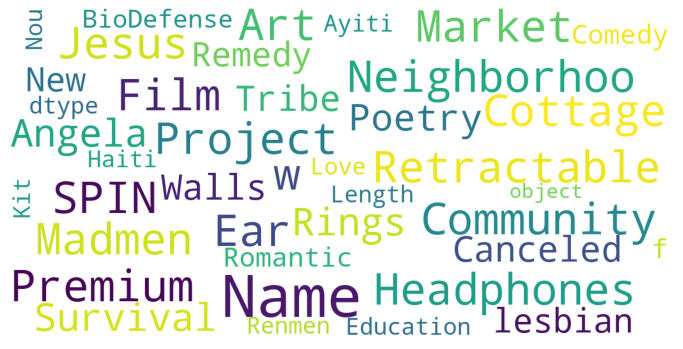

In [26]:
show_wordcloud(ksData[ksData.state == 0]['name'])

## Successful Projects

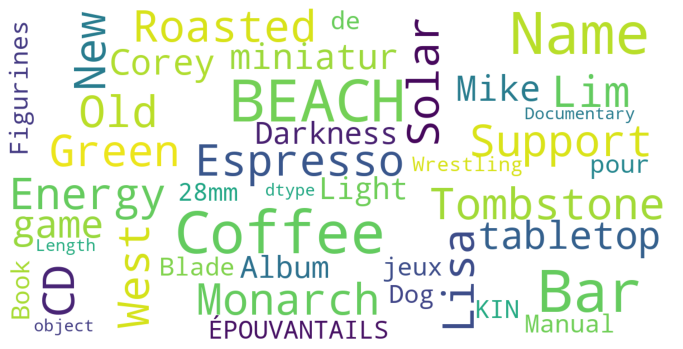

In [27]:
show_wordcloud(ksData[ksData.state == 1]['name'])

We will now perform some basic univariate statistical analysis on the following numeric predictors, in order to visualise the differences among these variables between `failed` and `successful`

>`name_length` <br>
>`campaign_length` <br>
>`usd_goal_real` <br>
> `& the 15 different categories from main_category`

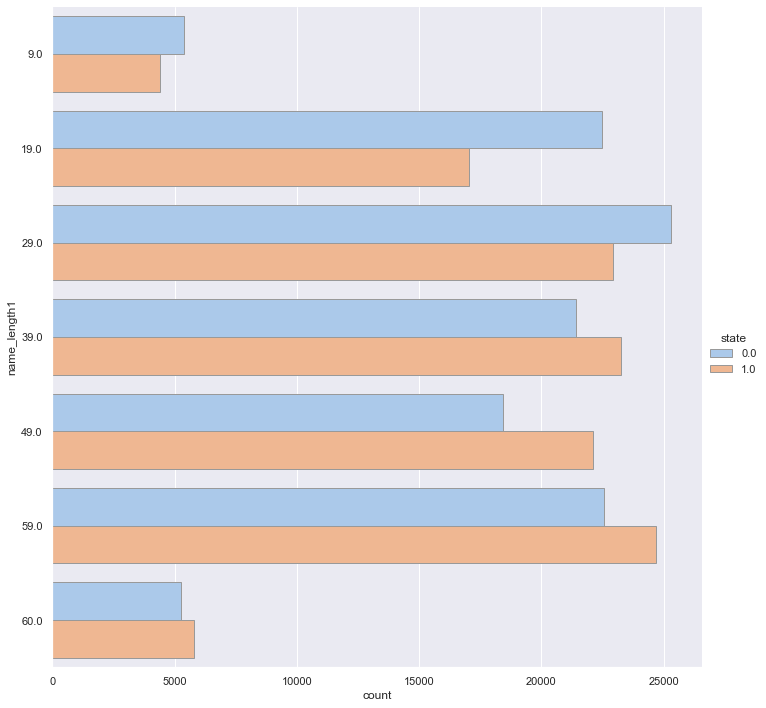

In [28]:
ksData.loc[(ksData["name_length"] >= 0) & (ksData["name_length"] < 10), "name_length1"] = 9
ksData.loc[(ksData["name_length"] >= 10) & (ksData["name_length"] < 19), "name_length1"] = 19 
ksData.loc[(ksData["name_length"] >= 20) & (ksData["name_length"] < 29), "name_length1"] = 29 
ksData.loc[(ksData["name_length"] >= 30) & (ksData["name_length"] < 39), "name_length1"] = 39 
ksData.loc[(ksData["name_length"] >= 40) & (ksData["name_length"] < 49), "name_length1"] = 49 
ksData.loc[(ksData["name_length"] >= 50) & (ksData["name_length"] < 59), "name_length1"] = 59 
ksData.loc[(ksData["name_length"] >= 60), "name_length1"] = 60
sb.catplot(y="name_length1", hue="state", 
           kind="count", height=10, aspect=1, 
           palette="pastel", edgecolor=".6", 
           data=ksData)

For easier visualisation, the name length is grouped into set, according to their range.

9.0 means length is between 0-9, 19 means it is within the range 10-19 and so on, count is the number of data points, and state 0 represents project failure.

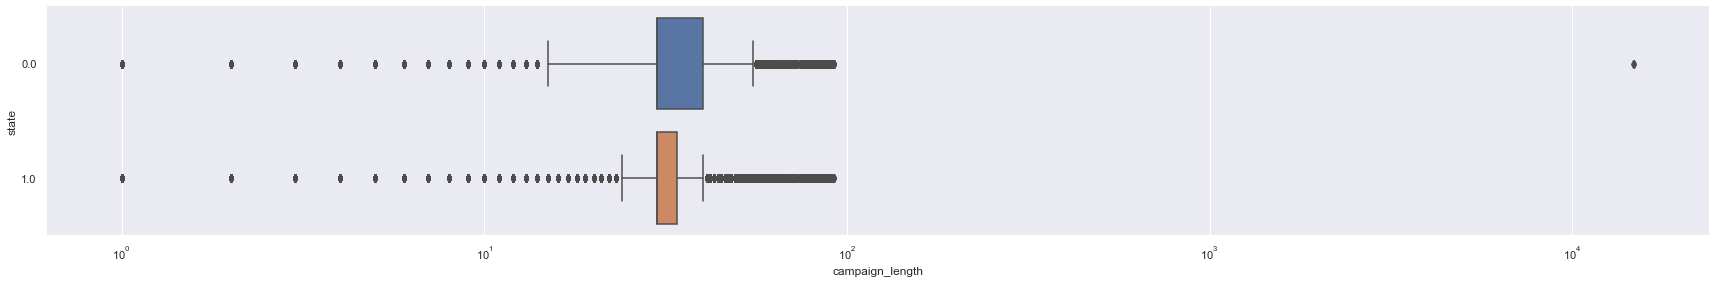

In [29]:
g = sb.catplot(x="campaign_length", y="state",
                kind="box", orient="h", height=4, aspect=6,
                data=ksData)
g.set(xscale="log")

From the boxplot against the state, the distribution of the campaign length, where state 0 represents failed projects, and 1.0 represents successful projects.

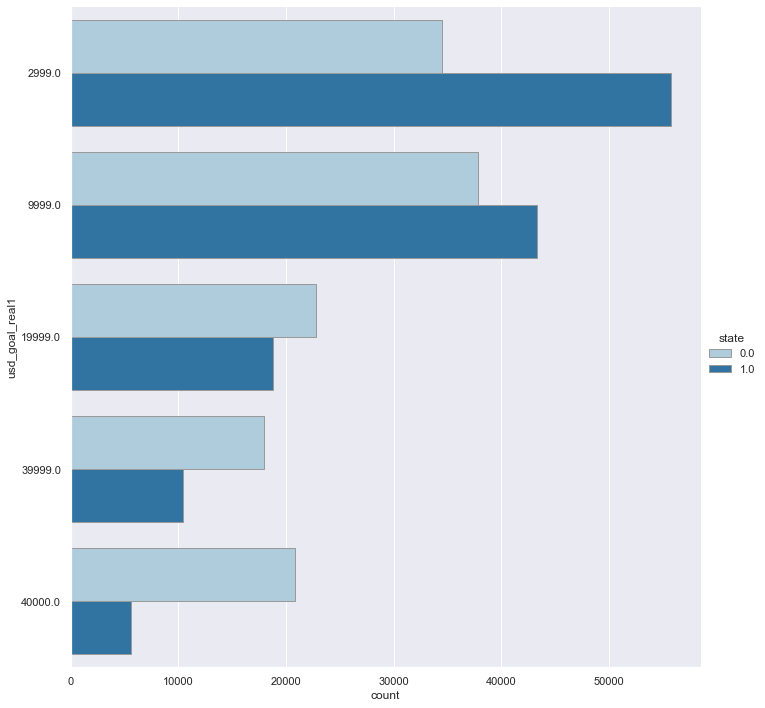

In [30]:
ksData.loc[(ksData["usd_goal_real"] >= 0) & (ksData["usd_goal_real"] < 3000), "usd_goal_real1"] = 2999
ksData.loc[(ksData["usd_goal_real"] >= 3000) & (ksData["usd_goal_real"] < 10000), "usd_goal_real1"] = 9999
ksData.loc[(ksData["usd_goal_real"] >= 10000) & (ksData["usd_goal_real"] < 20000), "usd_goal_real1"] = 19999
ksData.loc[(ksData["usd_goal_real"] >= 20000) & (ksData["usd_goal_real"] < 40000), "usd_goal_real1"] = 39999
ksData.loc[(ksData["usd_goal_real"] >= 40000), "usd_goal_real1"] = 40000
sb.catplot(y="usd_goal_real1", hue="state", 
           kind="count", height=10, aspect=1, 
           palette="Paired", edgecolor=".6", 
           data=ksData)

The barplot above is goal of the kickstarter project in USD on the x axis, where the value on y axis represents the range of the goal, where 2999 represent 0 to 2999, and 7999 represents 3000 to 9999 and so on.

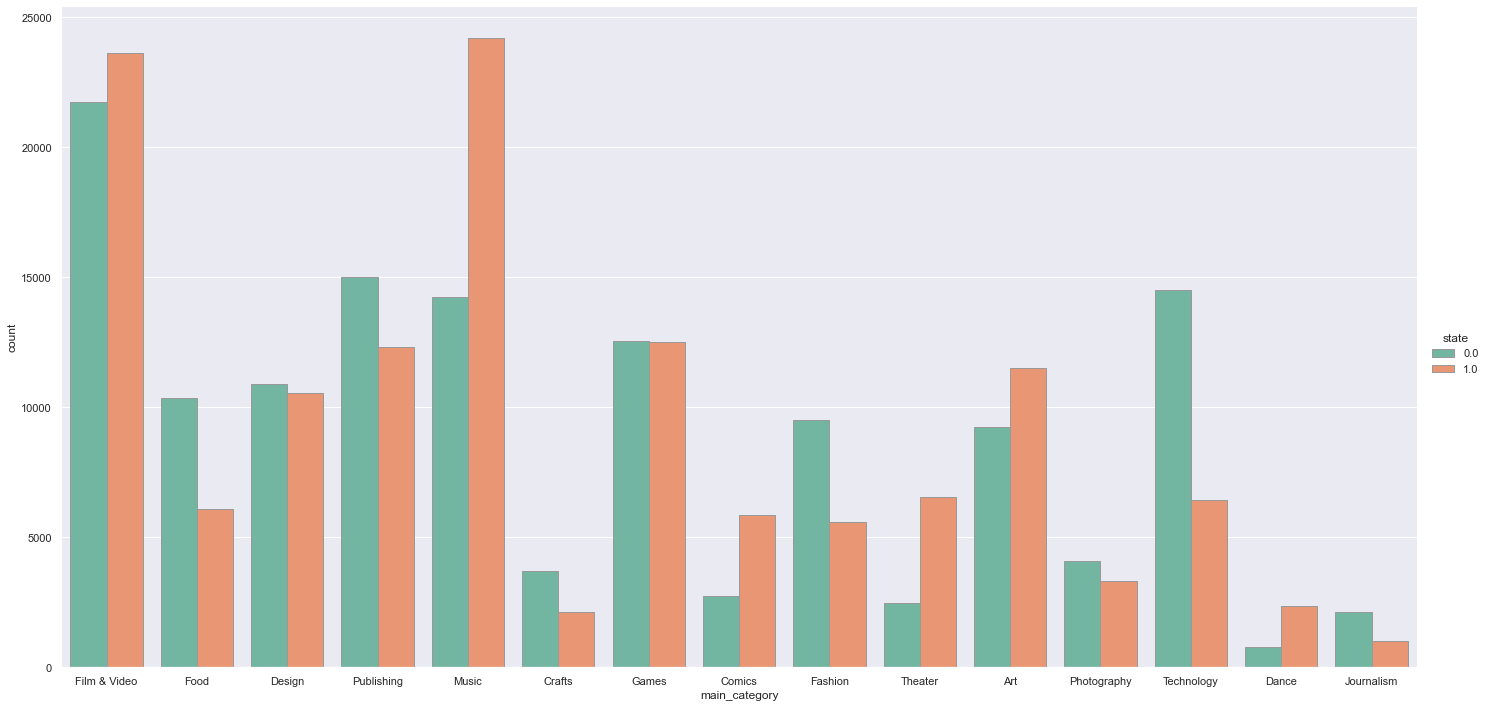

In [31]:
sb.catplot(x="main_category", hue="state", 
           kind="count", height=10, aspect=2, 
           palette="Set2", edgecolor=".6", 
           data=ksData)

Visualisation for the categories against the counts of success, and fail

# **Machine Learning Models

## Preparing Data

In [32]:
one_hot_data = pd.get_dummies(ksData['main_category'])
ksData.drop(columns=['main_category','usd_goal_real1','name_length1','name'], inplace = True)
ksData = ksData.join(one_hot_data)

Changing the categorial data into numerical data

In [33]:
train1 = ksData.sample(frac = 0.8, random_state = 25)
test1  = ksData.drop(train1.index)
print("Learning:", train1.shape)
print("Test: ", test1.shape)

Learning: (214330, 19)
Test:  (53582, 19)


In [34]:
trainX = train1.drop(columns = ['state'])
trainY = pd.DataFrame(train1['state'])
testX =test1.drop(columns = ['state'])
testY = pd.DataFrame(test1['state'])

## Decision Tree Classifier

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
tree1 = DecisionTreeClassifier(max_depth = 10)
tree1.fit(trainX, trainY)

DecisionTreeClassifier(max_depth=10)

<AxesSubplot:>

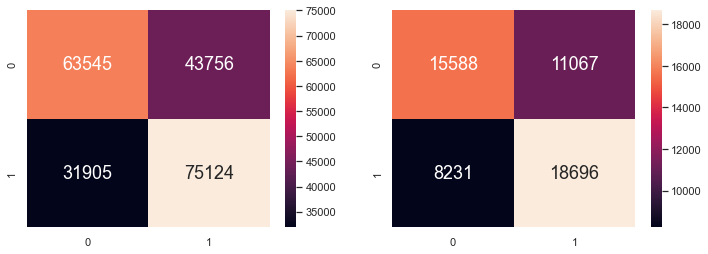

In [36]:
trainpredY = tree1.predict(trainX)
testpredY = tree1.predict(testX)
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(trainY, trainpredY),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(testY, testpredY), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [37]:
print("Classification Accuracy train set \t:", tree1.score(trainX, trainY))
print("Classification Accuracy train set \t:", tree1.score(testX, testY))

Classification Accuracy train set 	: 0.6469882890869221
Classification Accuracy train set 	: 0.639841737897055


## Gradient Boosting Classifier

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(trainX)
X_test_scale = scaler.transform(testX)

In [39]:
learning_rates = [0.05, 0.1, 0.25,0.55,0.75,1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(learning_rate = learning_rate)
    gb.fit(trainX, trainY)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(trainX, trainY)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(testX, testY)))

/Users/yyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Learning rate:  0.05
Accuracy score (training): 0.651
Accuracy score (validation): 0.651


/Users/yyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Learning rate:  0.1
Accuracy score (training): 0.656
Accuracy score (validation): 0.657


/Users/yyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Learning rate:  0.25
Accuracy score (training): 0.659
Accuracy score (validation): 0.659


/Users/yyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Learning rate:  0.55
Accuracy score (training): 0.663
Accuracy score (validation): 0.661


/Users/yyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Learning rate:  0.75
Accuracy score (training): 0.664
Accuracy score (validation): 0.659


/Users/yyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Learning rate:  1
Accuracy score (training): 0.664
Accuracy score (validation): 0.658


The most accurate model is with learning rate 0.55, which gives the highest accuracy score, when training and testing score combined. Hence, 0.55 will be our final learning rate.

In [40]:
gb = GradientBoostingClassifier(learning_rate = 0.55)
gb.fit(trainX, trainY)
print("Learning rate: ", 0.55)
print("Accuracy score (training): {0:.3f}".format(gb.score(trainX, trainY)))
print("Accuracy score (validation): {0:.3f}".format(gb.score(testX, testY)))

/Users/yyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Learning rate:  0.55
Accuracy score (training): 0.663
Accuracy score (validation): 0.661


## Random Forest Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(trainX,trainY)
y_pred=clf.predict(testX)

/var/folders/_4/t06r7vg562q1r51nwsfd_0hm0000gn/T/ipykernel_3792/1220844991.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(trainX,trainY)


In [42]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(testY, y_pred))

Accuracy: 0.6102235825463775


<AxesSubplot:>

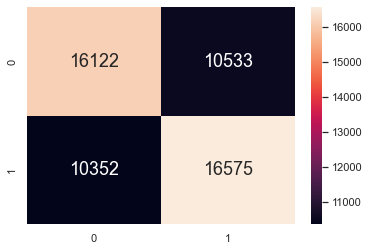

In [43]:
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(testY, y_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

The random forest method provided an accuracy of only 61%, means that it actually perform quite poor in the prediction. 

## Logistic Regression

In [44]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
sb.set(style="white")
sb.set(style="whitegrid", color_codes=True)

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(trainX, trainY)
y_pred = logreg.predict(testX)

/Users/yyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy of logistic regression classifier on train set: 0.5959828302150889
Accuracy of logistic regression classifier on test set: 0.5980926430517711


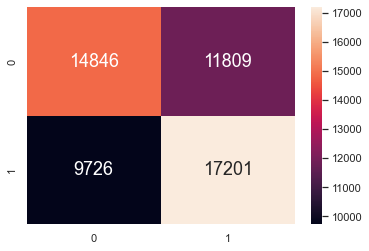

In [46]:
sb.heatmap(confusion_matrix(testY, y_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})
print('Accuracy of logistic regression classifier on train set: {:}'.format(logreg.score(trainX, trainY)))
print('Accuracy of logistic regression classifier on test set: {:}'.format(logreg.score(testX, testY)))

The logistic regression classifier did not perform very well on both train and test set, in fact it did worse than a simple decision Tree, hence it is not the suitable method for our project.

# Conclusion

## Data Driven Insights

### These are from the data visualisation part

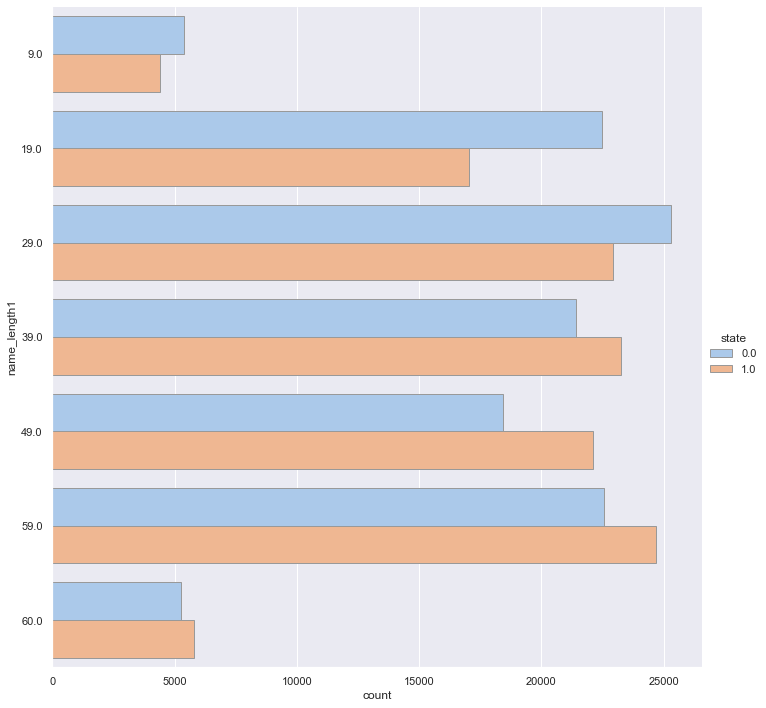

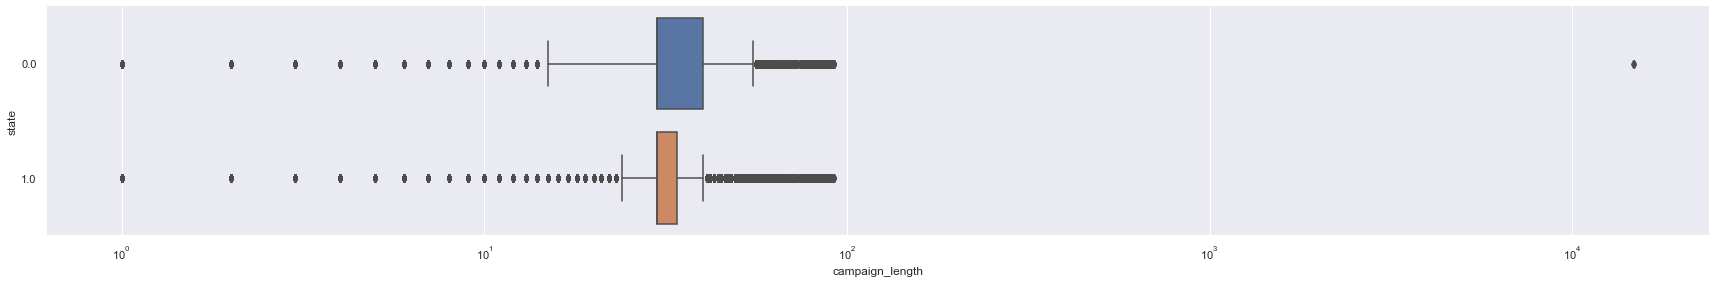

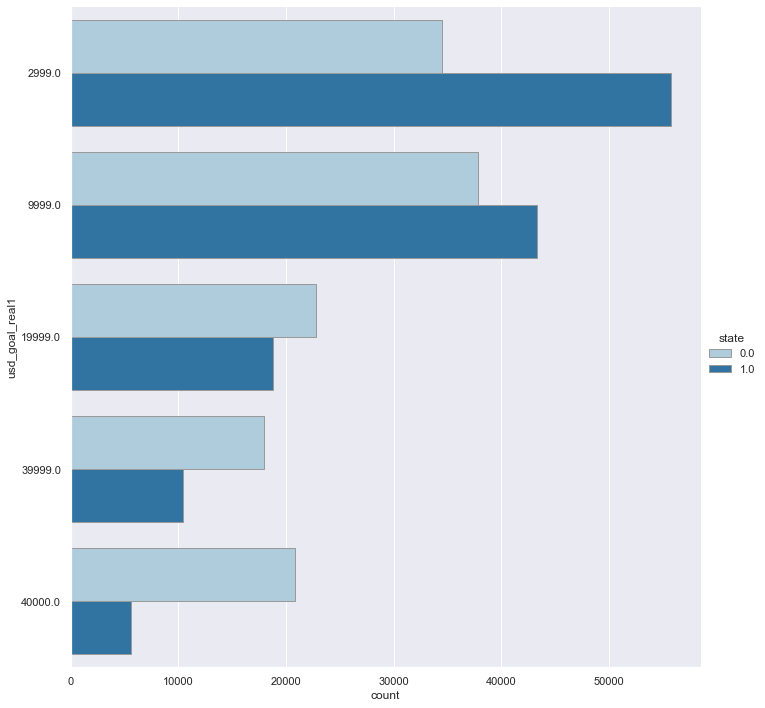

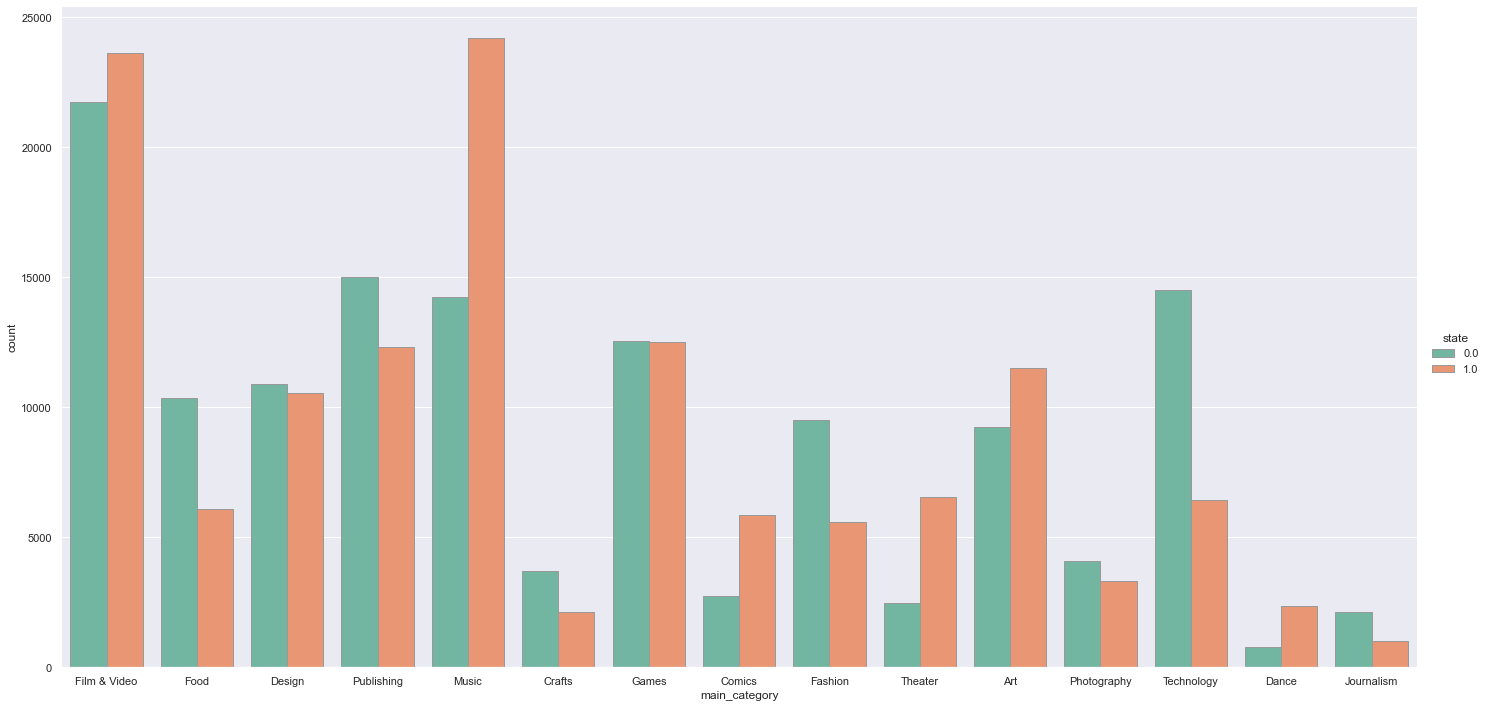

As seen from the figures, for most of the variables we used, there are some forms of trend between the state of the project, and the variables.

For campaign length however, the median and quartile values of the successful projects are not obviously distinguishable, and the main difference is that the box length is shorter, meaning the standard deviation in the successful projects is smaller.

### For all other variables, there is a trend in success and failure. 

For instance the name length, it can be seen that when name is short, there are more failures than success.
For USD goal real, the counts of failed project overtook the successful ones.
For main category, there are categories like technology, where likeliness of failing is double that of succeeding, and there is music where the likeliness of succeeding is double that of failing. 

### Hence, it can be seen that the variable campaign length is less important than the other variables, because there is no clear distinction or trend between the campaign length of successful projects, and the failed ones.

###  From the insights, the suggestions we have for someone interested in giving a shot for the KickStarter project, and wish to prevent failing, are:
- Make the name longer
- Make the goal in USD smaller in size
- try going for music, and avoid categories like food and technology

## Lessons learnt

The biggest lesson learnt is definitely the different ways to the data, especially when our dataset is special, where most of the variables available are categorial, and the prediction is also categorial. 

Another lesson learnt is that for such real-life projects, there are more factors than the listed numerical, or categorial variables that can be studied in our project, since the best accuracy we could get is only 66.1%

Thirdly, we got to know more about overfitting. when we try to run the classification all the way, although the accuracy for training set can be as high as 90+%, but the accuracy on test set went down to only 57%. It showed us that it may not be most accurate when it is closest to the training set.